In [130]:
import pickle
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import sys,os
from collections import Counter
import matplotlib
import matplotlib.cm as cm
from matplotlib.animation import FFMpegWriter
from collections import Counter
from matplotlib_venn import venn2

sys.path.append('../')
import visualizations
import constants
from config import targets

### Set parameters and load data

In [131]:
# Set parameters
constants.HISTORY_LENGTH=1
GRID_SIZE = 25
constants.GRID_SIZE = GRID_SIZE
TARGET = targets(GRID_SIZE)['square']
ITERATIONS = 50

In [132]:
# Load NCA

# filename = '../data/exp1_ksweep/k1/error_MI/error_MI_square25_2000gens_400ps_50i_k1_N4_run7.p'
# filename = '../data/exp1_ksweep/k45/error_MI/error_MI_square25_2000gens_400ps_50i_k45_N4_run12.p'
filename  = '../data/exp5_addcontrols_square/min_action_entropy/error_min_action_entropy_square25_2000gens_400ps_50i_k1_N4_run21.p'
# filename = '../data/exp1_ksweep/error/error_square25_1250gens_400ps_50i_k25_run23.p'
# filename = '../data/exp1_ksweep/error_phase1_error_phase2/error_phase1_error_phase2_square25_1250gens_400ps_50i_k25_run11.p'

with open(filename, 'rb') as f:
    stuff = pickle.load(f)
best = stuff[-2]
best.evaluate(objectives=['error', 'MI'], target=TARGET, g=0)
print(best.MI*-1)

0.7652011765824782


### Define H(X) and H(X|Y)

In [133]:
def shannon_entropy(X):
    # H(X)
    x_freq_dict = dict(Counter(X))

    Hx = 0

    for x in list(x_freq_dict.keys()):
        px = x_freq_dict[x]/len(X)

        Hx += px * np.log2(1/px)
    
    return Hx

In [134]:
def conditional_shannon_entropy(X,Y):
    # H(X|Y)
    x_freq_dict = dict(Counter(X))
    y_freq_dict = dict(Counter(Y))
    joint_freq_dict = dict(Counter(zip(X,Y)))

    Hx_y = 0

    for y in list(y_freq_dict.keys()):
        for x in list(x_freq_dict.keys()):
            py = y_freq_dict[y]/len(Y)

            try:
                pxy = joint_freq_dict[(x,y)]/len(X)
            except:
                continue

            Hx_y += pxy * np.log2(py/pxy)

    return Hx_y

### Run NCA simulation and collect action and sensor states

In [135]:
# Run NCA
history, sensors_timeseries, actions_timeseries = best.playback(iterations=ITERATIONS, return_SA=True)

Restructure action and sensor states into time series of shape n_cells x timesteps

In [136]:
# extract sensory values to a matrix
sensor_series_mat = np.zeros(shape=(constants.GRID_SIZE*constants.GRID_SIZE, len(sensors_timeseries[constants.HISTORY_LENGTH:])), dtype=int)
for t, sensor_mat in enumerate(sensors_timeseries[constants.HISTORY_LENGTH:]):
    
    sensor_mat = sensor_mat[1:-1, 1:-1,:] # remove padding

    cell_sensor_list = np.mean(sensor_mat[:,:,constants.NEIGHBORHOOD+1:],axis=2).flatten().astype(int)
    
    for i,sensor_val in enumerate(cell_sensor_list):

        sensor_series_mat[i,t] = sensor_val

print(sensor_series_mat.shape)

(625, 49)


In [137]:
# extract action values to a matrix
action_series_mat = np.zeros(shape=(constants.GRID_SIZE*constants.GRID_SIZE, len(actions_timeseries[:-constants.HISTORY_LENGTH])), dtype=int)
for t, action_mat in enumerate(actions_timeseries[:-constants.HISTORY_LENGTH]):
    
    action_mat = action_mat[1:-1, 1:-1,:] # remove padding

    cell_action_list = action_mat[:,:,-1].flatten().astype(int)
    
    for i,action_val in enumerate(cell_action_list):

        action_series_mat[i,t] = action_val

print(action_series_mat.shape)

(625, 49)


In [138]:
# Construct action sensor pairs
pairs = dict(Counter(zip(action_series_mat.flatten(), sensor_series_mat.flatten())))

### Compute entropies

In [139]:
# global
H_A = shannon_entropy(action_series_mat.flatten())
H_S = shannon_entropy(sensor_series_mat.flatten())
H_AS = conditional_shannon_entropy(action_series_mat.flatten(), sensor_series_mat.flatten())
H_SA = conditional_shannon_entropy(sensor_series_mat.flatten(), action_series_mat.flatten())

print(H_A, H_AS, H_A-H_AS)
print(H_S, H_SA, H_S-H_SA)

0.7804054806439975 0.015204304061520065 0.7652011765824774
2.340796020044816 1.5755948434623317 0.7652011765824844


### Create venn diagram

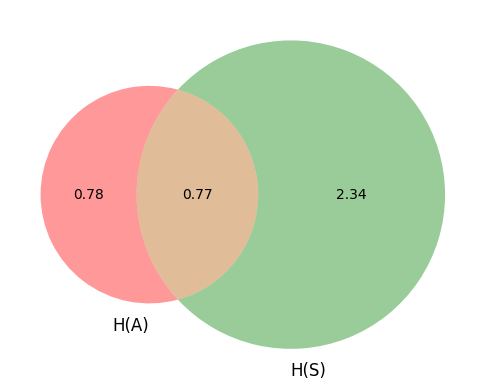

In [140]:
def round(x):
    return np.round(x,decimals=2)

venn2(subsets = (H_A, H_S, H_A-H_AS), set_labels = ('H(A)', 'H(S)'), subset_label_formatter=round)

### Action distributions

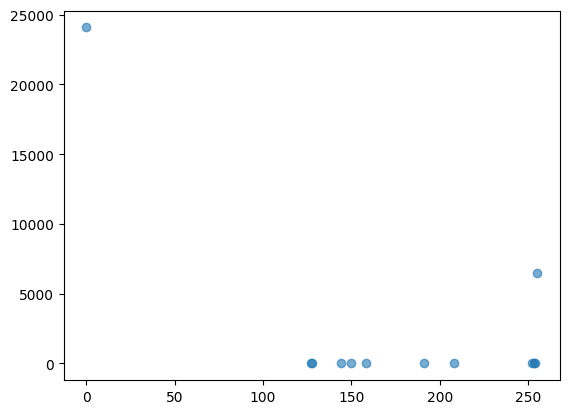

In [141]:
action_freq_dict = dict(sorted(Counter(action_series_mat.flatten()).items(), key=lambda item: item[0], reverse=False))

plt.scatter(action_freq_dict.keys(), action_freq_dict.values(),alpha=0.6)
